### **Formulas and Prep Code**

The module below preps all the functions needed to calculate a quantum state.
This program chooses to do all the calculations in matrix math, meaning:\
\
Given a quantum state (example)
$$
X_1 C_{12} X_0 H_1 \vert 0_2 0_1 0_0 \rangle
$$
It will choose to do the operations (identity gates are explained later):
$$
((X_0 \otimes H_1 \otimes I_2) \cdot (I_0 \otimes C_{12}) \cdot (I_0 \otimes X_1 \otimes I_2)) \vert 0_2 0_1 0_0 \rangle
$$

When calculating the gates, the code models them similarly to IBM's composer on the left alignment setting, and any empty spaces will be filled with identity gates. What that means is, given a circuit such as this: \
\
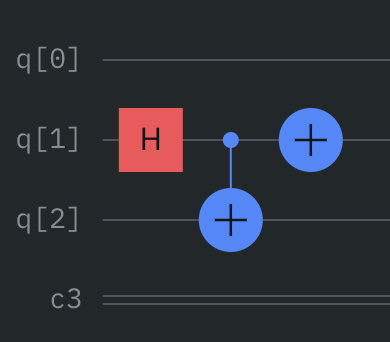


In the code, it will be modeled like this: \
\
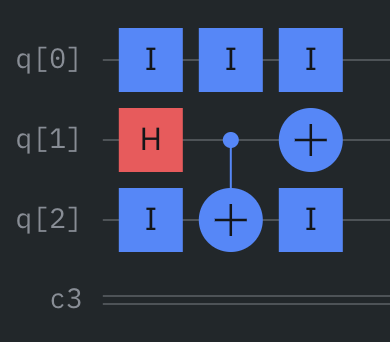

This is because when doing the final matrix multiplication of all the gates, all of the matrices must be the same dimensions. To make this happen, identity gates are substituted in to make sure that when finding the kronecker product of the gates, the resulting matrix is of uniform dimensions. 

One thing that gave me a particularly hard time was figuring out the matrix representation of a CNOT gate, given an arbitrary control and target.
After a bit (a lot) of time, the formula that I found worked was:
$$
CNOT_{a,b} = I_{2^{a - b}} \otimes \vert 0 \rangle \langle 0 \vert + (X \otimes I_{2^{a - b - 1}}) \otimes \vert 1 \rangle \langle 1 \vert
$$
when $a > b$ (control comes after the target). When $b > a$,
$$
CNOT_{a,b} =  \vert 0 \rangle \langle 0 \vert \otimes I_{2^{a - b}} + \vert 1 \rangle \langle 1 \vert \otimes (I_{2^{a - b - 1}} \otimes X)
$$

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import random

# basic gates, no input required
s_gates = {
    "h": (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]]),
    "x": np.array([[0, 1], [1, 0]]),
    "id": np.array([[1, 0], [0, 1]]),
    "s": np.array([[1, 0], [0, 0+1j]]),
    "t": np.array([[1, 0], [0, np.power(np.e, np.pi/4 * 1j)]]),
    "z": np.array([[1, 0], [0, -1]]),
    "y": np.array([[0, -1j], [1j, 0]]),
    "tdg": np.array([[1, 0], [0, np.power(np.e, -1j * np.pi / 4)]]),
    "sdg": np.array([[1, 0], [0, -1j]])
} 

# gates where input is required (cx is special case)
var_gates = {"rz", "p", "rx", "u", "ry", "cx"}

def make_var_gate(inputs: list) -> None: 
    """
    given a list input, returns the respective gate (this method is for gates that require inputs)

    args:
        inputs: list following the format [gateName, [args]], where gateName is a string and args is a list
                    for a unitary matrix, args = [theta, phi, lambda]
    """
    gate = inputs[0]
    theta = inputs[1][0]
    if gate == "u": 
        phi, lamb = inputs[1][1], inputs[1][2]
        return np.array([
            [np.cos(theta / 2), np.sin(theta / 2) * -np.power(np.e, 1j * lamb)],
            [np.sin(theta / 2) * np.power(np.e, 1j * phi), np.cos(theta / 2) * np.power(np.e, 1j * (lamb + phi))]
        ])
    elif gate == "rx":
        return np.array([
            [np.cos(theta / 2), -1j * np.sin(theta / 2)], 
            [-1j * np.sin(theta / 2), np.cos(theta / 2)]
        ])
    elif gate == "ry":
        return np.array([
            [np.cos(theta / 2), -np.sin(theta / 2)], 
            [np.sin(theta / 2), np.cos(theta / 2)]
        ])
    elif gate == "rz":
        return np.array([
            [np.power(np.e, -1j * theta / 2), 0], 
            [0, np.power(np.e, 1j * theta / 2)]
        ])
    elif gate == "p":
        return np.array([
            [1, 0], 
            [0, np.power(np.e, 1j * theta)]
        ])

def create_cnot(control: int, target: int):
    """
    returns the corresponding cnot gate matrix given a control and target

    pre:
        target != control
    args:
        control: position of the control qubit
        target: position of the target qubit
    return:
        cnot gate as an NDArray
    """
    if target == control:
        raise ValueError
    
    n = np.abs(target - control)
    h1, h2 = np.array([[1], [0]]), np.array([[1, 0]])
    houter = np.outer(h1, h2)

    v1, v2 = np.array([[0], [1]]), np.array([[0, 1]])
    vouter = np.outer(v1, v2)

    size = np.power(2, n)
    id1 = np.identity(size)
    id2 = np.identity(int(size / 2))
    
    if target < control:
        term1 = np.kron(houter, id1)
        term2 = np.kron(vouter, np.kron(id2, s_gates['x']))
        return term1 + term2

    term1 = np.kron(id1, houter)
    term2 = np.kron(np.kron(s_gates['x'], id2), vouter)
    return term1 + term2

def parse_cnot(instruction: str, instr_list: list) -> None:
    """
    parses a cnot gate instruction from a qasm file, adding the result to a given instruction list

    args:
        instruction: a given cnot instruction
        instr_list: a given instruction list (will be modified)
    """
    parts = instruction.split(" ")

    control, target = int(parts[1][2:][:-2]), int(parts[2][2:][:-1])
    start, fin = min(control, target), max(control, target)
    index = max(len(instr_list[control]), len(instr_list[target]))
    for i in range(start, fin + 1):
        padding = index - len(instr_list[i]) if index - len(instr_list[i]) > 0 else 0
        for _ in range(padding): 
            instr_list[i].append([])
            
        instr_list[i].append([]) if i == start or i == fin else instr_list[i].append(["cxb"])

    instr_list[control][-1] = ["cxc"]
    instr_list[target][-1] = ["cx"]

def choose_gate(gate_arr: str):
    """
    given an instruction, returns the corresponding gate as a matrix
    
    args:
        gate_arr = [gateName, [args] (if applicable)] where gateName is a string, and args contains the arguments of the gate, if there are any
    returns:
        gate as an NDArray
    """
    if not gate_arr:
        return s_gates['id']
    elif gate_arr[0] in s_gates:
        return s_gates[gate_arr[0]]
    else:
        return make_var_gate(gate_arr)

def combine_gates(gates: list):
    """
    combines all the gates from a given list of gates, returning the final fully combined gate\n
    kronecker tensors all gates in each column, then multiplies them together

    args:
        gates - list of all gates
    returns:
        final "gate" as an NDArray
    """
    final_gate = None
    for i in range(len(gates[0])):
        init_gate = None
        j = 0
        while j < len(gates):
            gate = None          
            if gates[j][i] and gates[j][i][0] in ["cxc", "cx"]:
                control, target = 0, 0
                if gates[j][i][0] == "cxc": 
                    control = j
                else: 
                    target = j

                for k in range(j + 1, len(gates)):
                    j += 1
                    if gates[k][i][0] in ["cxc", "cx"]:
                        if gates[j][i][0] == "cxc": 
                            control = k
                        else: 
                            target = k
                        break
                gate = create_cnot(control, target)
            else: 
                gate = choose_gate(gates[j][i])

            init_gate = gate if init_gate is None else np.kron(gate, init_gate)
            j += 1

        final_gate = init_gate if final_gate is None else np.matmul(init_gate, final_gate)

    return final_gate

def create_final_state(gates: list, qubits: int):
    """
    returns the final state of a quantum circuit given a list of gates and number of qubits

    args:
        gates - list of gates in the quantum circuit
        qubits - number of qubits
    returns:
        final state as an NDArray
    """
    comp_zero, state = np.array([[1], [0]]), np.array([[1], [0]])
    for _ in range(qubits - 1):
        state = np.kron(state, comp_zero)

    return np.matmul(combine_gates(gates), state)

### **Parsing Data**

When parsing the QASM file, this program first assumes that the file is in a similar format to the one IBM shows in their Quantum Composer. Significantly, the code is hardcoded to skip the first 2 lines of the QASM file, as IBM has these two lines of code at the top of their QASM file

```
OPENQASM 2.0
include "qelib1.inc";                                             
```

Parsing the instructions is fairly simple, as most gates are formatted 

```
{gate} q[{qubit_number}]
```

Some gates however, require inputs, such as the general unitary matrix, so their arguments also have to be parsed. However, this is just a matter of finding the arguments between the parentheses, as they're all formatted

```
{gate}({args}) q[{qubit_number}]
```

Parsing the CNOT gate was the most difficult, as it has some special things that need to be taken care of. First, as seen on the Quantum Composer, no gates can go in between the control and target of the CNOT gate. In the code, this is marked as `"cxb"`. Additionally, the control and target must be differentiated, so the control is labeled as `"cxc"` and the target as `"cx"`.

After parsing, all thats left to do is call the appropriate calculation functions and get the final state.


In [49]:
# get all lines from QASM File
instructions = []
q_reg = []
with open("pyfiles/Untitled circuit.qasm", "r") as f: # change file name / file path as needed
    for line in f:
        if "barrier" not in line and line != "\n": 
            if line[0] == "u":
                n = len(line)
                instructions.append(line[:n - 7].replace(" ", "") + " " + line[n - 6:n - 2])
            else: 
                instructions.append(line[:-2])

# parse all QASM File lines into instructions to be computed
instructions = instructions[2:]
for i in range(int(instructions[0][7:][:-1])):
    q_reg.append([])

for i in range(2, len(instructions)):
    op, n = instructions[i].split(), ""
    gateName, inputs = op[0], []

    # for gates with inputs
    if gateName not in s_gates and gateName != "cx":
        gateName = gateName[:1] if "(" in gateName[:2] else gateName[:2]

        inputs = (op[0][len(gateName) + 1: len(op[0]) - 1]).split(",")
        for i, v in enumerate(inputs): 
            inputs[i] = v.replace("pi", "np.pi")
            inputs[i] = eval(inputs[i])            

    if gateName == "cx": 
        parse_cnot(instructions[i], q_reg)
    else:
        for i in range(2, len(op[1]) - 1):
            n += op[1][i]

        n = int(n)
        operations = [gateName]
        if len(inputs): 
            operations.append(inputs)

        if not len(q_reg[n]) or q_reg[n][-1] != ["cxb"]: 
            q_reg[n].append(operations)
            continue

        placed = False
        for i in range(len(q_reg[n])):
            if not q_reg[n][i]:
                q_reg[n][i] = operations
                placed = True
                break
        
        if not placed: 
            q_reg[n].append(operations) 
    
max_len = max([len(i) for i in q_reg])
for i in q_reg:
    for _ in range(max_len - len(i)):
        i.append([])

# get final state and results
state = create_final_state(q_reg, len(q_reg)).ravel()
y_axis, chances = [], []
x_axis = []
for i in range(len(state)):
    formatter = format(i, f'0{int(np.log2(len(state)))}b')
    percentage = np.power(np.abs(state[i]), 2)

    chances.append(percentage)
    y_axis.append(percentage * 100)
    x_axis.append(formatter)

[['x'], ['h'], ['cxc'], [], []]
[['ry', [1.5707963267948966]], ['cx'], ['cxb'], ['t'], ['sdg']]
[['h'], ['cxc'], ['cx'], ['tdg'], []]


### **Simulating and Displaying Results**

After everything is calculated, the results of the calculation are displayed, with the expected probabilites of each state graphed.

A small simulation is also run based on these probabilities, with those results also graphed. By default, the number of shots is 8192, but this can always be changed.

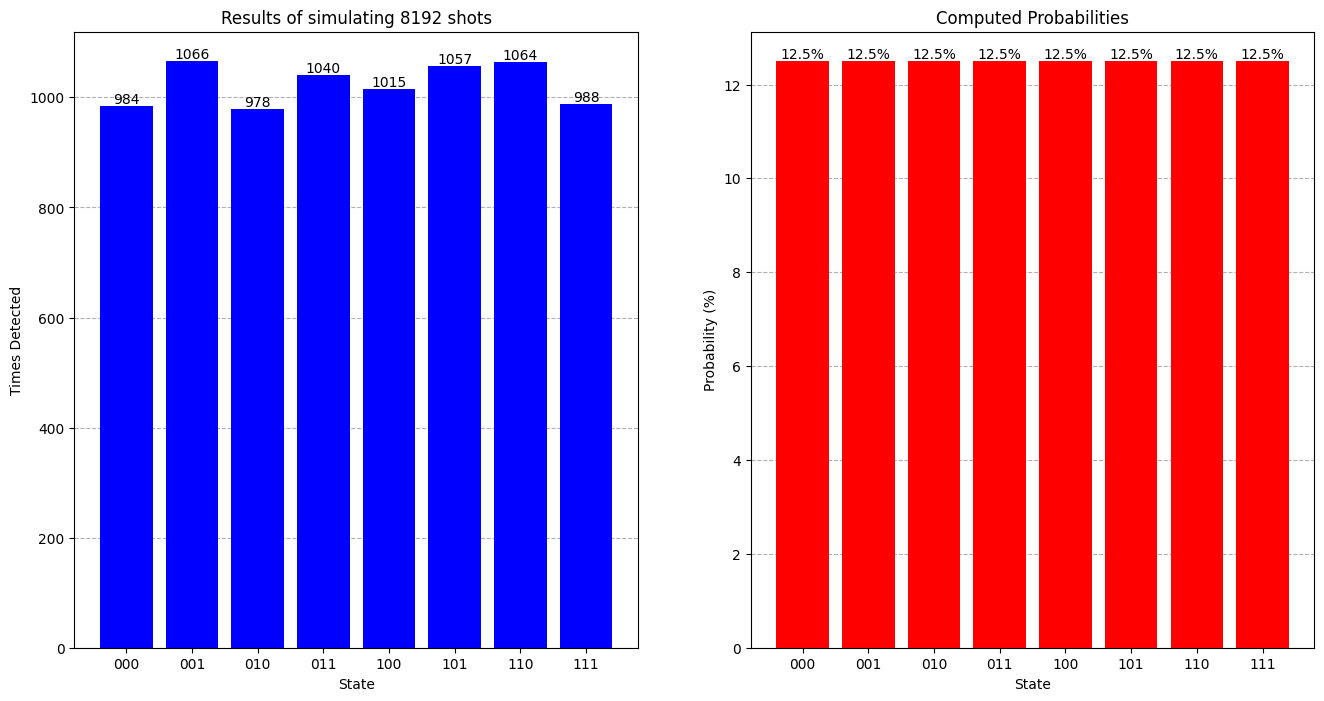

In [50]:
# simulating quantum circuit with x number of shots (default 8192)
shots = 8192
shots_remaining = shots
sim_results = [0] * len(chances)
while shots_remaining != 0:
    for i, v in enumerate(chances):
        if random.random() < v:
            sim_results[i] += 1
            shots_remaining -= 1
        
        if shots_remaining == 0: break

# show result of simulation
fig, ax = plt.subplots(ncols=2, figsize=(max(len(x_axis) * 2, 10), max(6, len(x_axis))))
sim_plt = ax[0]
bars = sim_plt.bar(x_axis, sim_results, color="blue")
sim_plt.set_xlabel("State")
sim_plt.set_ylabel("Times Detected")
sim_plt.set_title(f"Results of simulating {shots} shots")
sim_plt.set_axisbelow(True)
sim_plt.yaxis.grid(linestyle="dashed")
sim_plt.bar_label(bars, labels=[i if i != 0 else '' for i in sim_results]);

# show computed probabilities
prob_plt = ax[1]
bars = prob_plt.bar(x_axis, y_axis, color="red")
prob_plt.set_title("Computed Probabilities")
prob_plt.set_ylabel("Probability (%)")
prob_plt.set_xlabel("State")
prob_plt.set_axisbelow(True)
prob_plt.yaxis.grid(linestyle="dashed")
prob_plt.bar_label(bars, labels=[f"{round(i, 2)}%" if i != 0 else '' for i in y_axis]);